# Yelp Dataset Modelling

## Additional Data Preparation

We must start our modelling journey with little bit more data preparation.

In [33]:
# import modules and libraries
import pandas as pd
import numpy as np
import modules.data_processing as data_processing
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import shap
import pickle 

As response we've selected binary encoded variable satisfied, whihc has value 1 if business have 4.5 and more stars and 0 otherwise.

In [2]:
# load data
df = pd.read_csv('Yelp_business_data_processed2.csv', na_values="")

response = 'satisfied'
weights = 'review_count'
exclude_cols = ['name', 'latitude', 'longitude', 'stars', 'unsatisfied', 'is_open', 'avg_time_open_weekend',
           'review_count_binned', 'avg_time_open_week_binned', 'avg_time_open_weekend_binned', 'city']
numeric_cols = ['RestaurantsPriceRange2', 'RestaurantsPriceRange2_Unknown', 'avg_time_open_week', 
                'avg_time_open_week_Unknown', 'avg_time_open_weekend_Unknown']
categoric_cols = [col for col in list(df.columns) if col not in [response] + [weights] + exclude_cols + numeric_cols]

Since models require only numeric data we have to create one hot encoding for each categoric variables. Newly created dummy variables will replace categorical variables for model training.

In [3]:
df_modelling = df.drop(exclude_cols, axis=1)

for catvar in categoric_cols:
    df_modelling = data_processing.encode_categoric_variables(df_modelling, [catvar], []) 
    
# exclude unknowns, at first part of our analysis we are iterested more in filled data
unknown_levels = [col for col in df_modelling if "Unknown" in col]

df_modelling = df_modelling.drop(categoric_cols + unknown_levels, axis=1)

In [4]:
df_modelling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150346 entries, 0 to 150345
Columns: 212 entries, review_count to categories_classified_Travel & Transportation_encoded
dtypes: float64(2), int64(210)
memory usage: 243.2 MB


After encoding we have more than 200 variables, now all numeric type. We are finally ready to train some models! Since we have bigger number of predictors we can consider to use some method to select only variables with strongest connection to response and investigate them.

## Regularization

Machine learning models are versatile tools, we can use it for multiple purposes. In this and next section we will show how to use it for variable selection. Regularized models are one of the approaches to indicate most interesting variables. Fitting model with Lasso penalty selects most important variables first. Before we fit model we have to normalize predictors, since regularized models are sensitive to unscaled data. Because we aren't using it for prediction only as indication of variables with useful potential, we don't need to split data and leave part out of training for validation.

In [5]:
scaler = StandardScaler()
df_modelling_standardized = pd.DataFrame(scaler.fit_transform(df_modelling.drop([response, weights], axis=1)), columns=df_modelling.drop([response, weights], axis=1).columns)
df_modelling_standardized['intercept'] = 1

We had to tune parameter C, which represents strength of penalty. Lower value means that penalty is stronger and model fit less coefficients, we are interested to see top 30 coefficients so we had to find value of C that allows model to fit 30 coefficients. We can take a look what are the best variables for regularized logistic regression. 

In [7]:
logistic = LogisticRegression(solver="liblinear", random_state=0, C = 0.00065, penalty="l1", tol=0.001)

logistic.fit(df_modelling_standardized, df_modelling[response])
positive = [coef!=0 for coef in logistic.coef_]
print(f'Number of fitted coefficients: {sum(positive[0])}')

logistic_features = []
for index, col in enumerate(df_modelling_standardized.columns):
    if list(positive[0])[index]:
        logistic_features.append(col)

print(f'Fitted predictors: {logistic_features}')

Number of fitted coefficients: 31
Fitted predictors: ['RestaurantsPriceRange2', 'avg_time_open_week', 'state_AB_encoded', 'state_CA_encoded', 'state_NJ_encoded', 'state_NV_encoded', 'ByAppointmentOnly_True_encoded', 'BusinessAcceptsCreditCards_False_encoded', 'BikeParking_False_encoded', 'BikeParking_True_encoded', 'RestaurantsDelivery_True_encoded', 'WheelchairAccessible_False_encoded', 'WheelchairAccessible_True_encoded', 'HappyHour_False_encoded', 'OutdoorSeating_False_encoded', 'HasTV_True_encoded', 'DogsAllowed_True_encoded', 'Alcohol_full_bar_encoded', 'RestaurantsAttire_casual_encoded', 'RestaurantsGoodForGroups_True_encoded', 'DriveThru_True_encoded', 'BusinessAcceptsBitcoin_False_encoded', 'AcceptsInsurance_False_encoded', 'AcceptsInsurance_True_encoded', 'BYOB_True_encoded', 'BusinessParking_street_True_encoded', 'Ambience_classy_False_encoded', 'HairSpecializesIn_africanamerican_False_encoded', 'categories_classified_Construction & Contractors_encoded', 'categories_classifie

We have 30 best predictors and intercept fitted in model. In the data exploration notebook we will look at all of these variables to find out whether it really worth to include it into model.

## Feature Importance

As example we will use random forest and GBM models, both provides feature importance calculation. With feature importance it is revealed which variables has strongest influence on model prediction. We can assume that it could be good idea to focus on these variables as its key role in model indicates stronger relation with response variable. This feature is very helpful in case of big datasets with high number of potential predictors. With this approach we can narrow down number of predictors to examine and fit into model eventually.

### Random Forest

We have selected random forest as second model that we are going to use for variable selection.

In [8]:
feature_names = df_modelling.drop([response, weights], axis=1).columns.values.tolist()
forest = RandomForestClassifier(random_state=0)
forest.fit(df_modelling.drop([response, weights], axis=1), df_modelling[response], sample_weight=df_modelling[weights])

RandomForestClassifier(random_state=0)

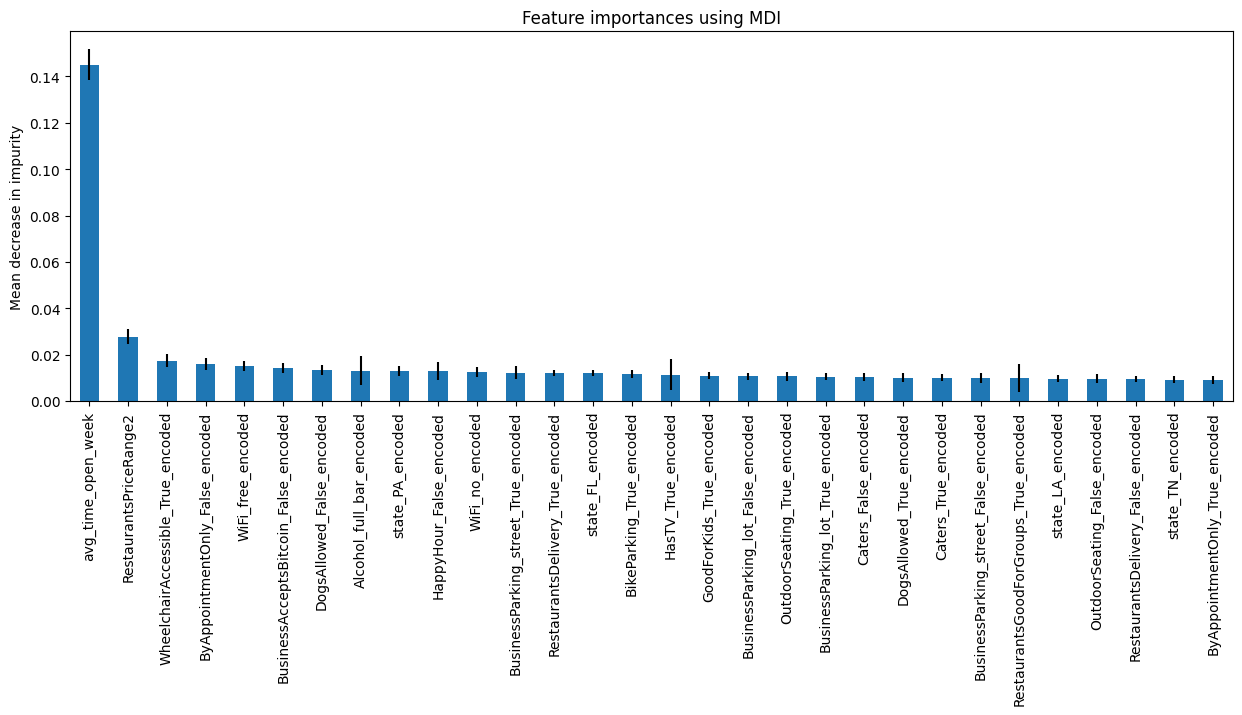

In [9]:
# number of predictors that we want to see in feature importance graph
n = 30

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_important_features = [x for _, x in sorted(zip(importances, feature_names), reverse=True)]
importance_std = [x for _, x in sorted(zip(importances, std), reverse=True)]

forest_importances = pd.Series(sorted(importances, reverse=True)[0:n], index=forest_important_features[0:n])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=importance_std[0:n], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

fig.set_figwidth(15)

### GBM

GBM has similar feature importance as random forest.

In [10]:
gbm_model = GradientBoostingRegressor(random_state=0, learning_rate=0.1, max_depth=10)
gbm_model.fit(df_modelling.drop([response, weights], axis=1), df_modelling[response], sample_weight=df_modelling[weights])

GradientBoostingRegressor(max_depth=10, random_state=0)

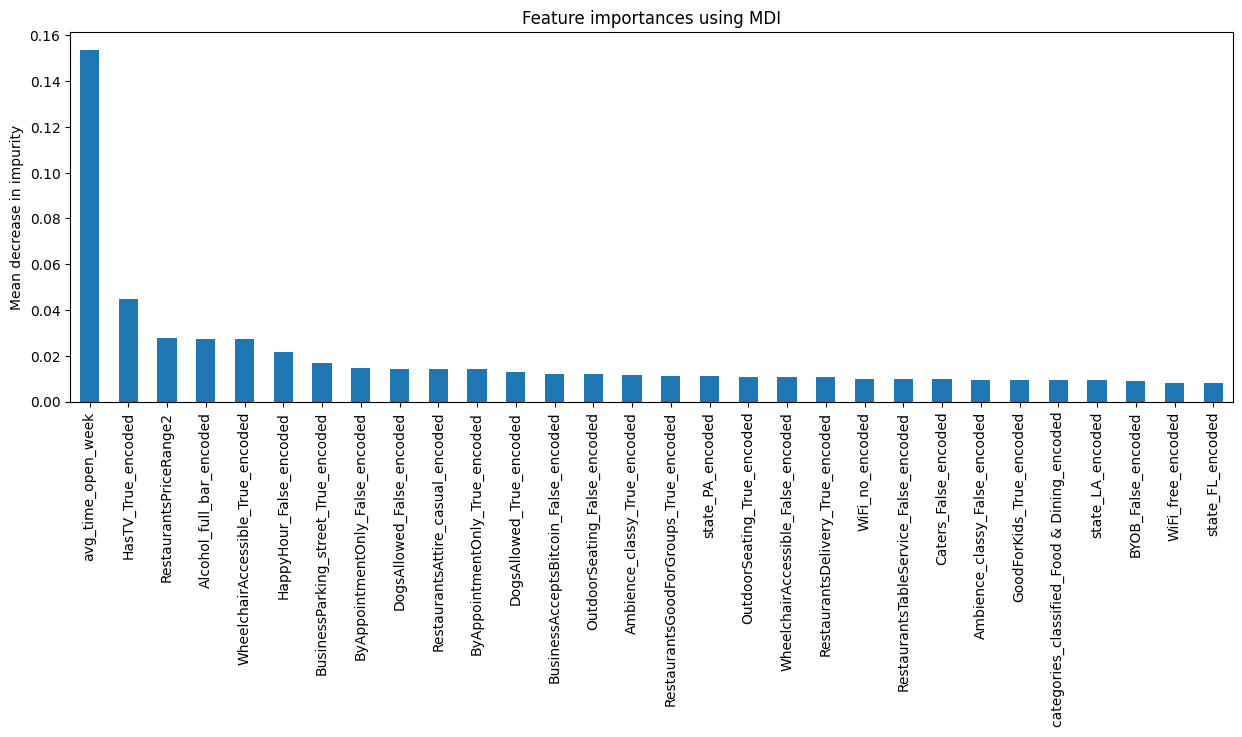

In [11]:
n = 30 

gbm_importances = gbm_model.feature_importances_
gbm_important_features = [x for _, x in sorted(zip(gbm_importances, feature_names), reverse=True)]
gbm_importance = pd.Series(sorted(gbm_importances, reverse=True)[0:n], index=gbm_important_features[0:n])

fig, ax = plt.subplots()
gbm_importance.iloc[0:n].plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

fig.set_figwidth(15)

## Modelling


### Logistic Regression

Regression types of models are very simple and biggest advantage is easy interpretation of fitted features. We should focus on selecting the best features, eliminate correlated features and those which aren't significant by checking p-values of coeficients. It is iterative process.

In [20]:
import statsmodels.api as sm

logistic_features_selected = logistic_features

# split data to train and test
X_train, X_test, y_train, y_test = train_test_split(df_modelling_standardized, df[response], test_size=0.2, stratify=df[response], random_state=0)

logit_model=sm.Logit(y_train,X_train[logistic_features_selected])
logit_model_fit =logit_model.fit()
print(logit_model_fit.summary())


Optimization terminated successfully.
         Current function value: 0.528437
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              satisfied   No. Observations:               120276
Model:                          Logit   Df Residuals:                   120245
Method:                           MLE   Df Model:                           30
Date:                Thu, 06 Jul 2023   Pseudo R-squ.:                  0.1214
Time:                        18:16:52   Log-Likelihood:                -63558.
converged:                       True   LL-Null:                       -72344.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
RestaurantsPrice

Modelling summary showed that we have two insignificant predictordd fitted in model HasTV_True_encoded and Ambience_classy_False_encoded. We can exclude it and fit model again.

In [21]:
significant_predictors = [logistic_features_selected[index] for index, significant in enumerate(list(logit_model_fit.summary2().tables[1]['P>|z|'] < 0.05)) if significant]

logit_model=sm.Logit(y_train,X_train[significant_predictors])
logit_model_fit=logit_model.fit()
print(logit_model_fit.summary())

Optimization terminated successfully.
         Current function value: 0.528469
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              satisfied   No. Observations:               120276
Model:                          Logit   Df Residuals:                   120247
Method:                           MLE   Df Model:                           28
Date:                Thu, 06 Jul 2023   Pseudo R-squ.:                  0.1214
Time:                        18:17:11   Log-Likelihood:                -63562.
converged:                       True   LL-Null:                       -72344.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
RestaurantsPrice

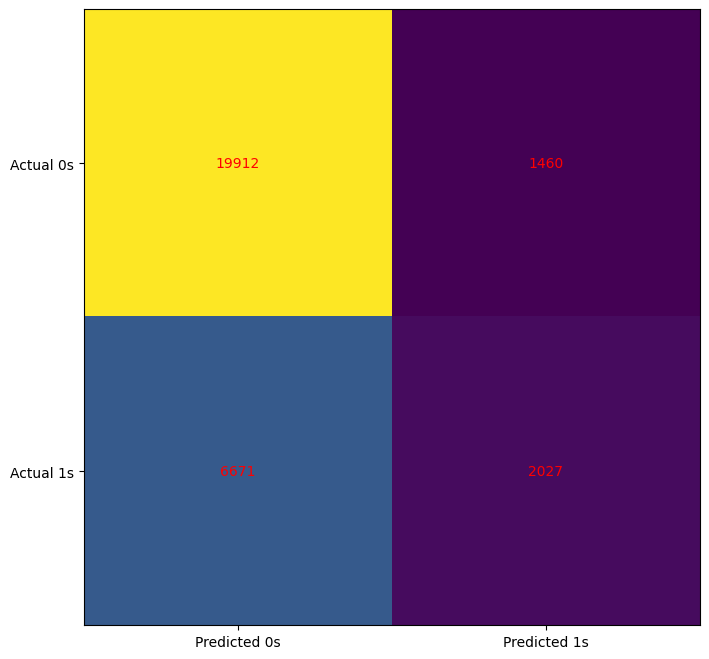

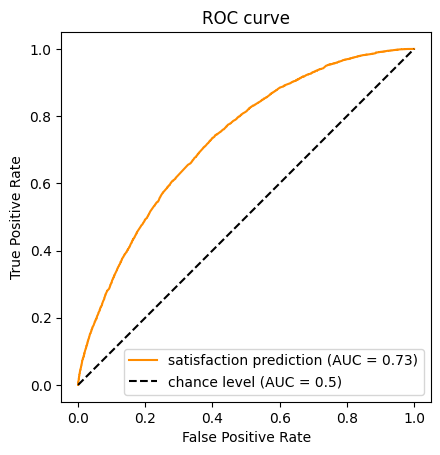

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, list(map(round, result.predict(X_test[significant_predictors]))))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

RocCurveDisplay.from_predictions(y_test, result.predict(X_test[significant_predictors]), name="satisfaction prediction", color="darkorange")
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend()
plt.show()

Advantage of GLM models such as logistic regression is easy interpretability of model. We can easily say what is the effect of particular predictor on model prediction. Intepretation of logistic regression is based on knowledge that coefficients have linear relation to log odds ratio of outcome probability (ln(p/1-p) where p is probability of response to be 1). Positive coefficients have positive effect on odds ratio and negative has negative effect.

In [22]:
print(logit_model_fit.summary())

                           Logit Regression Results                           
Dep. Variable:              satisfied   No. Observations:               120276
Model:                          Logit   Df Residuals:                   120247
Method:                           MLE   Df Model:                           28
Date:                Thu, 06 Jul 2023   Pseudo R-squ.:                  0.1214
Time:                        18:17:29   Log-Likelihood:                -63562.
converged:                       True   LL-Null:                       -72344.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                               coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
RestaurantsPriceRange2                                      -0.2821      0.009    -32.273      0.000      -0.299      

We can see that RestaurantPriceRange2, avg_time_open_week, RestaurantsDelivery_True_encoded, Alcohol_full_bar_encoded, RestaurantsAttire_casual_encoded, DriveThru_True_encoded and other with negative coefficients have negative impact on satisfaction. On the other hand ByAppointmentOnly_True_encoded, WheelchairAccessible_True_encoded, BusinessParking_street_True_encoded, DogsAllowed_True_encoded and other with positive coefficient have positive impact on satisfaction.

We still must look back at the data and investigate more because even coefficients might be missleading, for example WheelchairAccessible_False_encoded and WheelchairAccessible_True_encoded have both positive coefficients. We might want to conclude that both have positive impact, but the truth is that the rest of data is missing and it has very low satisfaction rate. Therefore both seems to have strong positive impact, which might not be true. So we need to find out why so much data is missing. Our theory is that if business owners do extra work and make business wheelchair friendly they let the people know about it more likely than businesses without wheelchair friendly adjustments. So probably only the WheelchairAccessible_True_encoded has positive impact on satisfaction. 

## Random Forest

Another type of model Random Forest can be used in our situation as well. It is decision tree based algorithm.

In [23]:
for depth in range(5,26):
    forest_predictors = forest_important_features[0:n]
    forest_model = RandomForestClassifier(random_state=0, max_depth=depth)
    forest_model.fit(X_train[forest_predictors], y_train)

    cm = confusion_matrix(y_test, forest_model.predict(X_test[forest_predictors]))
    print(f"Depth: {depth} \nTest accuracy: {(cm[1][1] + cm[0][0])/sum(sum(cm))}")
    print("*" * 20)

Depth: 5 
Test accuracy: 0.7184569338210841
********************
Depth: 6 
Test accuracy: 0.7224143664782174
********************
Depth: 7 
Test accuracy: 0.7268041237113402
********************
Depth: 8 
Test accuracy: 0.728965746591287
********************
Depth: 9 
Test accuracy: 0.7311273694712338
********************
Depth: 10 
Test accuracy: 0.7319255071499834
********************
Depth: 11 
Test accuracy: 0.734718989025607
********************
Depth: 12 
Test accuracy: 0.7358829398071167
********************
Depth: 13 
Test accuracy: 0.7360824742268042
********************
Depth: 14 
Test accuracy: 0.7372796807449284
********************
Depth: 15 
Test accuracy: 0.7377452610575325
********************
Depth: 16 
Test accuracy: 0.735783172597273
********************
Depth: 17 
Test accuracy: 0.7348187562354506
********************
Depth: 18 
Test accuracy: 0.7345859660791486
********************
Depth: 19 
Test accuracy: 0.7328566677751912
********************
Depth: 20 
Test ac

We can see that predictive power of model started to drop after increasing tree depth above 16. This is the point where we start to overfit data. As optimal depth parameter we can select depth 16.

In [30]:
forest_predictors = forest_important_features[0:n]
forest_model = RandomForestClassifier(random_state=0, max_depth=16)
forest_model.fit(X_train[forest_predictors], y_train)

cm = confusion_matrix(y_test, forest_model.predict(X_test[forest_predictors]))

Accuracy with train data:	 0.8033606039442616
Accuracy with test data:	 0.735783172597273


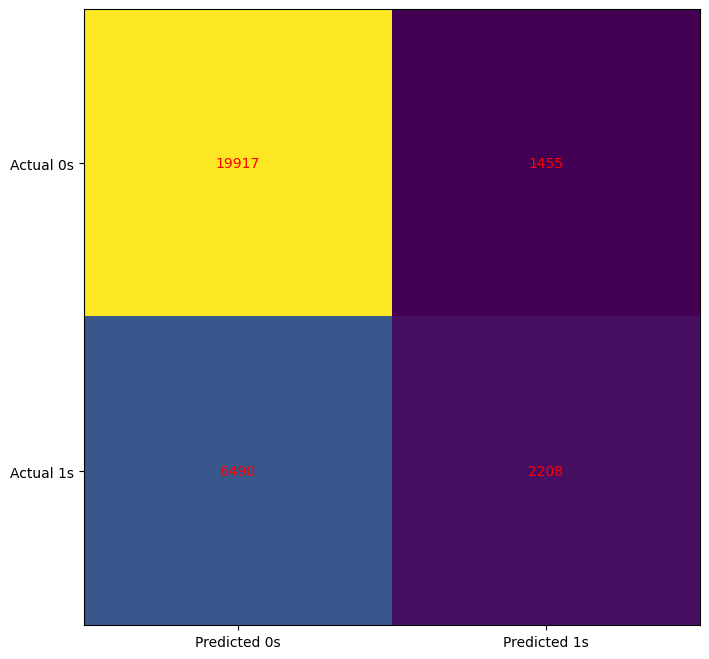

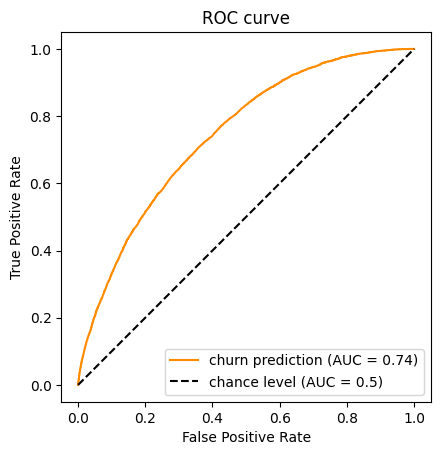

In [31]:
cm = confusion_matrix(y_train, forest_model.predict(X_train[forest_predictors]))
print("Accuracy with train data:\t", (cm[1][1] + cm[0][0])/sum(sum(cm)))
cm = confusion_matrix(y_test, forest_model.predict(X_test[forest_predictors]))
print("Accuracy with test data:\t", (cm[1][1] + cm[0][0])/sum(sum(cm)))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

RocCurveDisplay.from_predictions(y_test, forest_model.predict_proba(X_test[forest_predictors])[::,1], name="churn prediction", color="darkorange")
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend()
plt.show()

## GBM

Another decision three based algorithm is GBM. We can try to use it for our problem. Let's first optimize learning rate parameter.

In [27]:
gbm_predictors = gbm_important_features[0:n]

def threshold_prediction(x, threshold=0.5):
    if x>=threshold:
        res = 1
    else:
        res = 0
    return res

lr_list = [0.005, 0.01, 0.025, 0.05, 0.075, 0.1]
for value in lr_list:
    gbm_model = GradientBoostingRegressor(random_state=0, learning_rate=value, max_depth=10)
    gbm_model.fit(X_train[gbm_predictors], y_train)

    print("With learning rate", value)
    cm = confusion_matrix(y_train, [threshold_prediction(pred_val) for pred_val in gbm_model.predict(X_train[gbm_predictors])])
    print("Accuracy with train data:\t", (cm[1][1] + cm[0][0])/sum(sum(cm)))
    cm = confusion_matrix(y_test, [threshold_prediction(pred_val) for pred_val in gbm_model.predict(X_test[gbm_predictors])])
    print("Accuracy with test data:\t", (cm[1][1] + cm[0][0])/sum(sum(cm)))


With learning rate 0.005
Accuracy with train data:	 0.7172503242542153
Accuracy with test data:	 0.7132357831725973
With learning rate 0.01
Accuracy with train data:	 0.7436562572749343
Accuracy with test data:	 0.7274692384436315
With learning rate 0.025
Accuracy with train data:	 0.7713425787355749
Accuracy with test data:	 0.7382773528433655
With learning rate 0.05
Accuracy with train data:	 0.7847450863015065
Accuracy with test data:	 0.7374459594280013
With learning rate 0.075
Accuracy with train data:	 0.7938907180152316
Accuracy with test data:	 0.7366810774858663
With learning rate 0.1
Accuracy with train data:	 0.8005753433768998
Accuracy with test data:	 0.7363817758563352


As most optimal learning rate we have 0.025, which has even slightly better accuracy on test data then random forest.

Accuracy with train data:	 0.7713425787355749
Accuracy with test data:	 0.7382773528433655


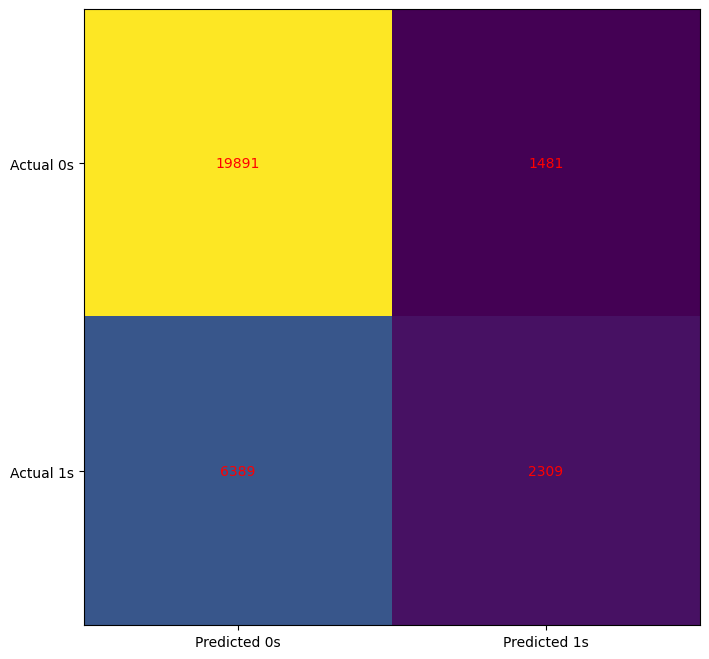

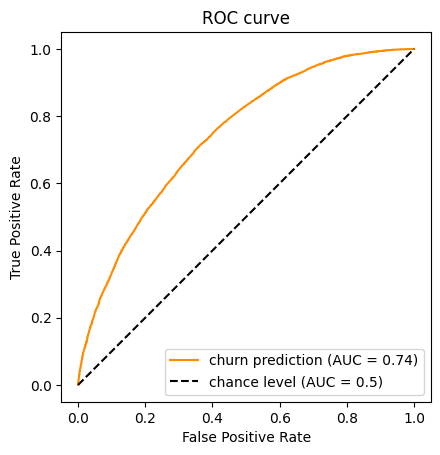

In [28]:
gbm_model = GradientBoostingRegressor(random_state=0, learning_rate=0.025, max_depth=10)
gbm_model.fit(X_train[gbm_predictors], y_train)

cm = confusion_matrix(y_train, [threshold_prediction(pred_val) for pred_val in gbm_model.predict(X_train[gbm_predictors])])
print("Accuracy with train data:\t", (cm[1][1] + cm[0][0])/sum(sum(cm)))
cm = confusion_matrix(y_test, [threshold_prediction(pred_val) for pred_val in gbm_model.predict(X_test[gbm_predictors])])
print("Accuracy with test data:\t", (cm[1][1] + cm[0][0])/sum(sum(cm)))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

RocCurveDisplay.from_predictions(y_test, gbm_model.predict(X_test[gbm_predictors]), name="churn prediction", color="darkorange")
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend()
plt.show()

We can save dataset with predictions.

In [32]:
df_output = df.copy()

df_output['gbm_predicted_bin'] = [threshold_prediction(pred_val) for pred_val in gbm_model.predict(df_modelling_standardized[gbm_predictors])]
df_output['rf_predicted_bin'] = forest_model.predict(df_modelling_standardized[forest_predictors])
df_output['logit_predicted_bin'] =  [threshold_prediction(pred_val) for pred_val in logit_model_fit.predict(df_modelling_standardized[significant_predictors])]

df_output['gbm_predicted'] = gbm_model.predict(df_modelling_standardized[gbm_predictors])
df_output['rf_predicted'] = [pred[1] for pred in forest_model.predict_proba(df_modelling_standardized[forest_predictors])]
df_output['logit_predicted'] =  logit_model_fit.predict(df_modelling_standardized[significant_predictors])


df_output.to_csv("data/Yelp_business_data_prediction.csv", index=False)

## Shapley Values

Random forest and GBM have both little bit better results then logistic regression, however unlike regression model types both have limited interpretability. However options how to interpret blackbox model exists. With Shapley Values we are able to tell what is contribution of particular variable to model prediction. It's kind of like interpret coefficients of regression.

In [32]:
X_shap_gbm = shap.utils.sample(X_train[gbm_predictors], 100)

# compute the SHAP values for the gbm model
# explainer_gbm = shap.Explainer(gbm_model.predict, X_shap_gbm)
# shap_values_gbm = explainer_gbm(X_train[gbm_predictors])

Permutation explainer: 120277it [1:43:49, 19.28it/s]                            


Shapley values are computationally demanding, it took 1 hour and 43 minutes to calculate them, but it can provide useful insights in similar way as linear regression. We have saved calculated shapley values. so it can be imported without need to recalculate it.

In [41]:
# with open('files/gbm_shapley_value', 'wb') as file_gbm_shapley:
#     pickle.dump(shap_values_gbm, file_gbm_shapley)

In [34]:
with open('files/gbm_shapley_value', 'rb') as file:
    shap_value_test = pickle.load(file)

Waterfall chart can tell us contribution of variables to prediction of single input.

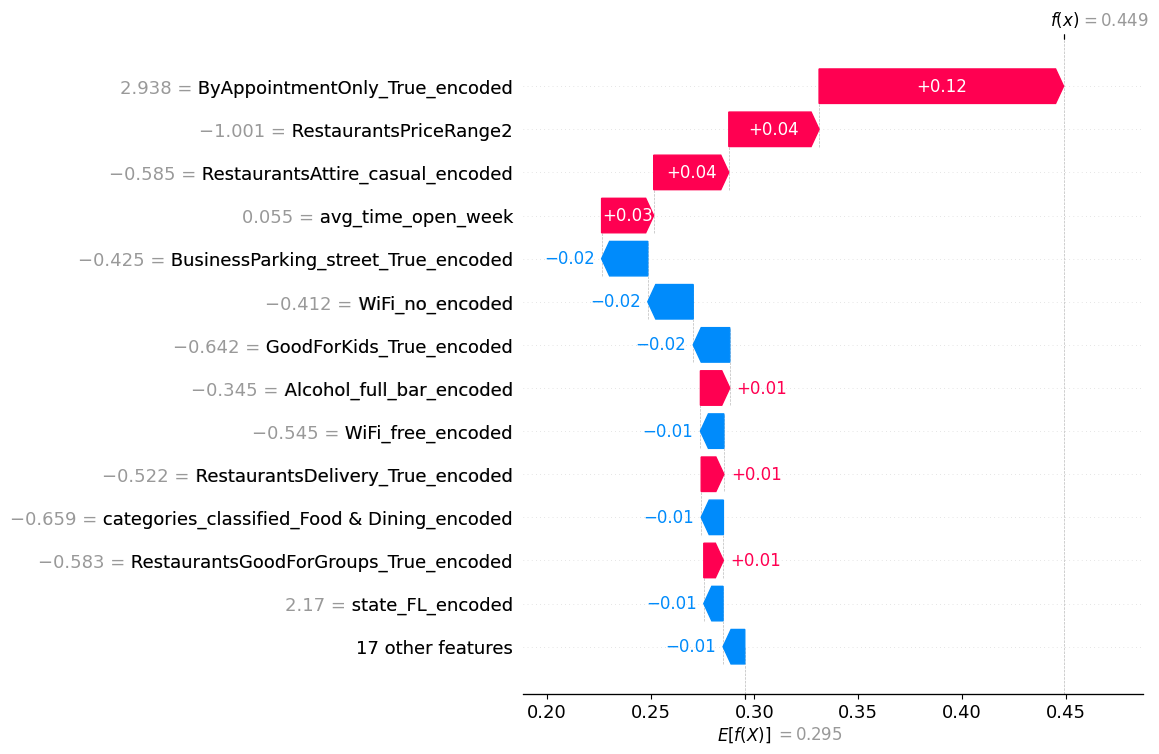

In [35]:
shap.plots.waterfall(shap_value_test[0], max_display=14)

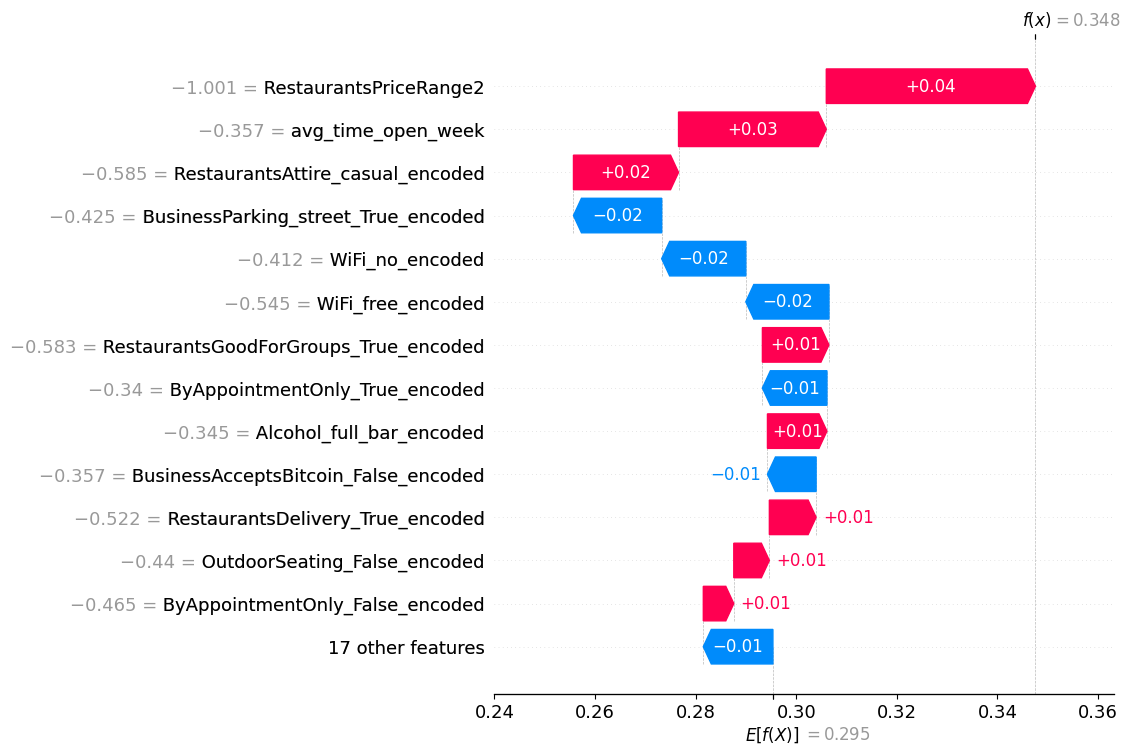

In [5]:
shap.plots.waterfall(shap_value_test[1], max_display=14)

Scatter plots provide information about overal contribution of variable.

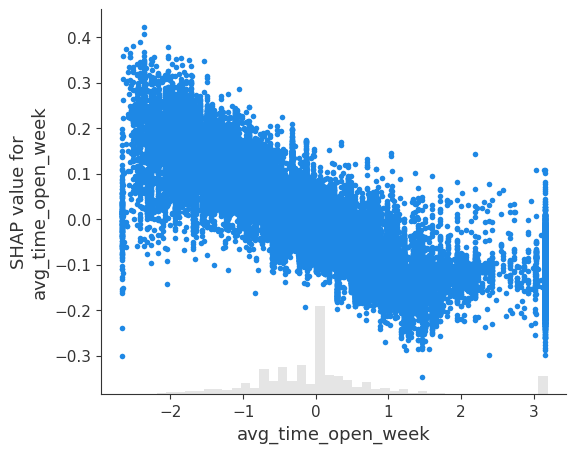

In [7]:
shap.plots.scatter(shap_value_test[:,"avg_time_open_week"])

For example avg_time_open_week tells us that higher values of this variable tend to have negative impact on satisfaction rate.

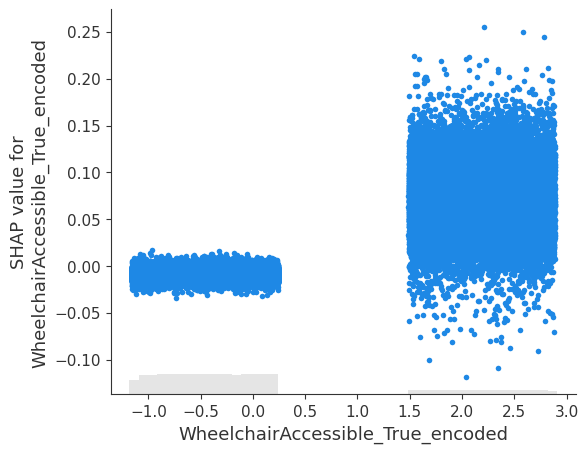

In [8]:
shap.plots.scatter(shap_value_test[:,"WheelchairAccessible_True_encoded"])

WheelchairAccessible_True tell us that this variable has positive impact if value of encoded variable is positive. We see that value isn't 0 and 1 because we did normalize data!

Violin plot does summary of contribution of all variables

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


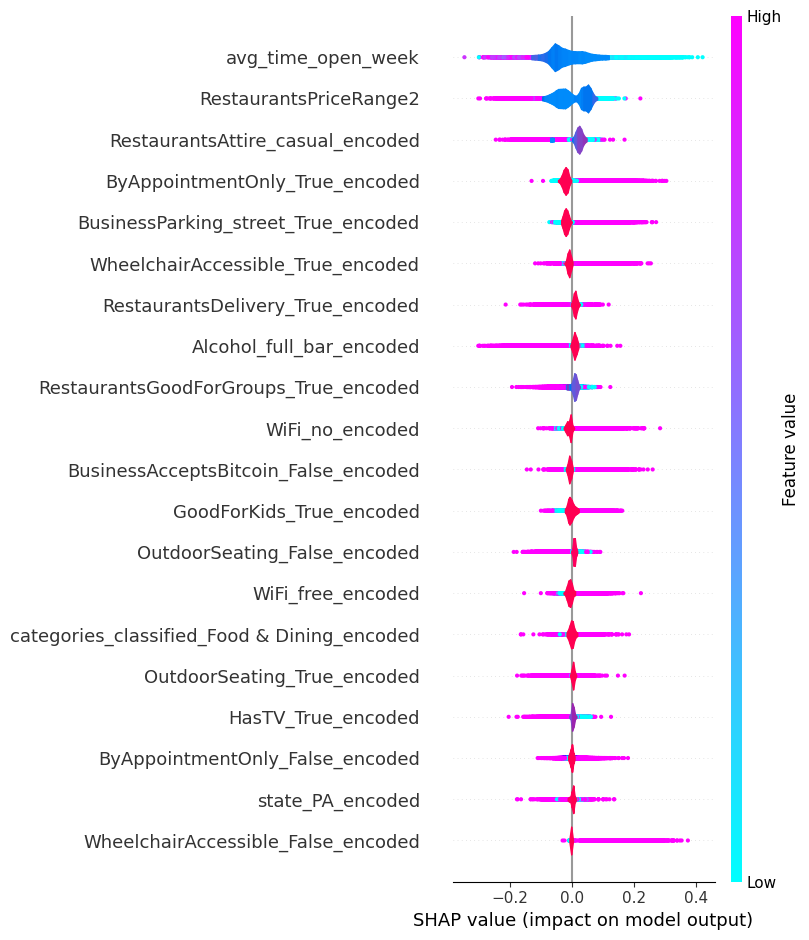

In [40]:
# shap.plots.violin(shap_value_test)
shap.summary_plot(shap_value_test, X_train[gbm_predictors], color='cool',show=False, plot_type='violin',cmap='cool')